<a href="https://colab.research.google.com/github/Konerusudhir/kaggle_datasets/blob/master/course_tensorflow/TemperaturePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 
     |████████████████████████████████| 450kB 50.9MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstal

In [0]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
print(tf.__version__)

2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-01-19 19:41:07--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-01-19 19:41:08 (2.95 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



(3650,)

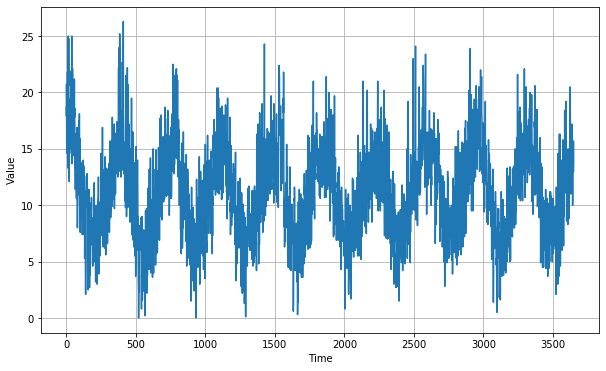

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(100).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 64
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  #  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  #  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(30, activation="relu"),
  #  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation="relu"),
  #  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-6)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
39/39 [==============================] - 5s 118ms/step - loss: 54.8884 - mae: 55.5114
Epoch 2/100
39/39 [==============================] - 1s 26ms/step - loss: 45.6396 - mae: 46.1770
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 32.8183 - mae: 33.5552
Epoch 4/100
39/39 [==============================] - 1s 26ms/step - loss: 17.2239 - mae: 17.9348
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 8.2047 - mae: 8.7049
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 6.5893 - mae: 7.0653
Epoch 7/100
39/39 [==============================] - 1s 25ms/step - loss: 5.9027 - mae: 6.4047
Epoch 8/100
39/39 [==============================] - 1s 26ms/step - loss: 5.4467 - mae: 5.9294
Epoch 9/100
39/39 [==============================] - 1s 24ms/step - loss: 5.0362 - mae: 5.5339
Epoch 10/100
39/39 [==============

[1e-06, 0.1, 0, 60]

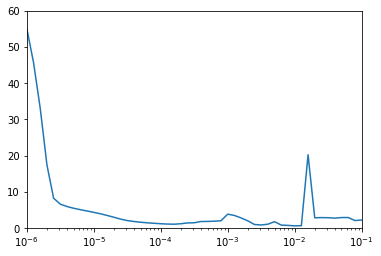

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  # tf.keras.layers.LSTM(60, return_sequences=True),
  # tf.keras.layers.LSTM(60, return_sequences=True),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(30, activation="relu"),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation="relu"),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

loss_checkpoint = ModelCheckpoint(
        'model_low_val_loss.h5', 
        monitor='val_loss', 
        mode='min', 
        modelsave_best_only=True)
mae_checkpoint = ModelCheckpoint(
        'model_low_val_mae.h5', 
        monitor='val_mae', 
        mode='min', 
        modelsave_best_only=True)
early_stopping = EarlyStopping(
    monitor='val_mae', 
    mode='min', 
    min_delta=0.0001, 
    patience=20)

callbacks = [loss_checkpoint, mae_checkpoint, early_stopping]

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, validation_data=valid_set, callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3870      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

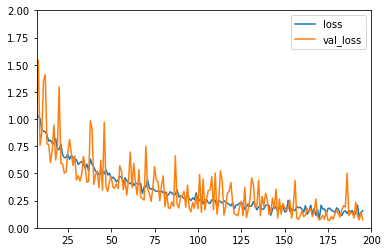

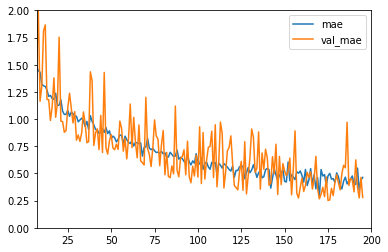

In [0]:
import pandas as pd
# pd.DataFrame(model.history.history)
model_loss = pd.DataFrame(model.history.history)
# model_loss.head()
model_loss[['loss','val_loss']].plot(ylim=[0,2], xlim=[7,200])
model_loss[['mae','val_mae']].plot(ylim=[0,2], xlim=[7,200])

Low Val MAE Model - MAE: 1.8277302


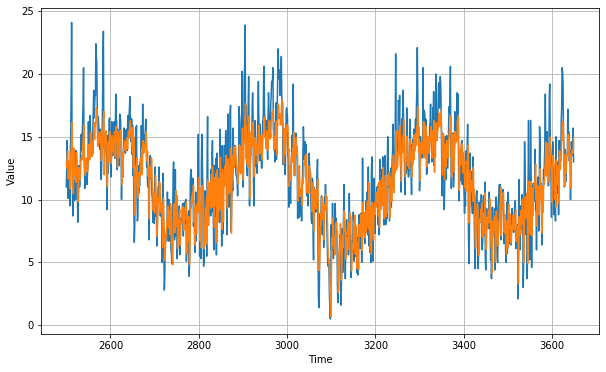

In [0]:
# window_size=60
model.load_weights('model_low_val_mae.h5')
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print("Low Val MAE Model - MAE: " + str(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()))

Low Val Loss Model - MAE: 1.8277302


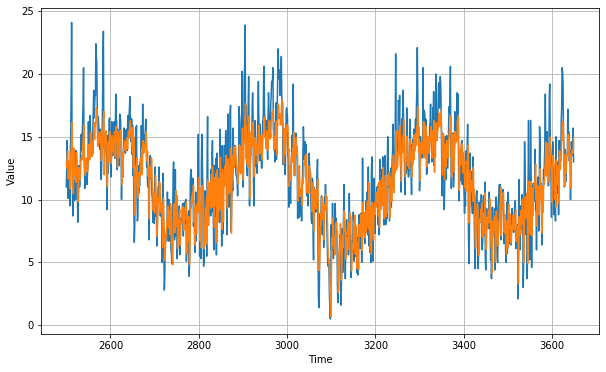

In [0]:
# window_size=60
model.load_weights('model_low_val_loss.h5')
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print("Low Val Loss Model - MAE: " + str(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()))

In [0]:
print(rnn_forecast)

[12.822822 12.517049 13.282    ... 13.673568 13.773474 14.94863 ]
